In [1]:
test_results = {
    'output_aggregation': {},
    'late_fusion_mlp': {},
    'late_fusion_pooling': {},
    'early_fusion': {},
    '3D_CNN': {},
    'dual_stream': {},
}

for category in test_results:
    test_results[category] = {
        'with_leakage': {},
        'without_leakage': {}
    }

# 1. With leakage

## 1.1. Load the dataset

In [2]:
from utils.globalConst import *

In [3]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
from torchvision import transforms as T
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

from DatasetLoader.FrameImageDataset import FrameImageDataset
from DatasetLoader.FrameVideoDataset import FrameVideoDataset

train_transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(5),
    T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    T.ToTensor(),
])

val_test_transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
])

- - -
## 1.2. Train the models

In [5]:
import torch.optim as optim
import torch.nn as nn

import json

### 1.2.1. Output aggregation

In [6]:
frameimage_train_loader = DataLoader(
    dataset=FrameImageDataset(split='train', transform=train_transform, leakage=True), 
    batch_size=BATCH_SIZE, 
    shuffle=True
)
frameimage_val_loader = DataLoader(
    dataset=FrameImageDataset(split='val', transform=val_test_transform, leakage=True), 
    batch_size=BATCH_SIZE, 
    shuffle=True
)
frameimage_test_loader = DataLoader(
    dataset=FrameImageDataset(split='test', transform=val_test_transform, leakage=True), 
    batch_size=BATCH_SIZE, 
    shuffle=True
)

In [7]:
framevideolist_train_loader = DataLoader(
    dataset=FrameVideoDataset(split='train', transform=train_transform, leakage=True, stack_frames=False), 
    batch_size=BATCH_SIZE, 
    shuffle=True
)
framevideolist_val_loader = DataLoader(
    dataset=FrameVideoDataset(split='val', transform=val_test_transform, leakage=True, stack_frames=False), 
    batch_size=BATCH_SIZE, 
    shuffle=True
)
framevideolist_test_loader = DataLoader(
    dataset=FrameVideoDataset(split='test', transform=val_test_transform, leakage=True, stack_frames=False), 
    batch_size=BATCH_SIZE, 
    shuffle=True
)

Epoch 50/50:
 Train Loss: 0.1540	 Train Accuracy: 94.86%
 Validation Loss: 0.5224	 Validation Accuracy: 88.75%


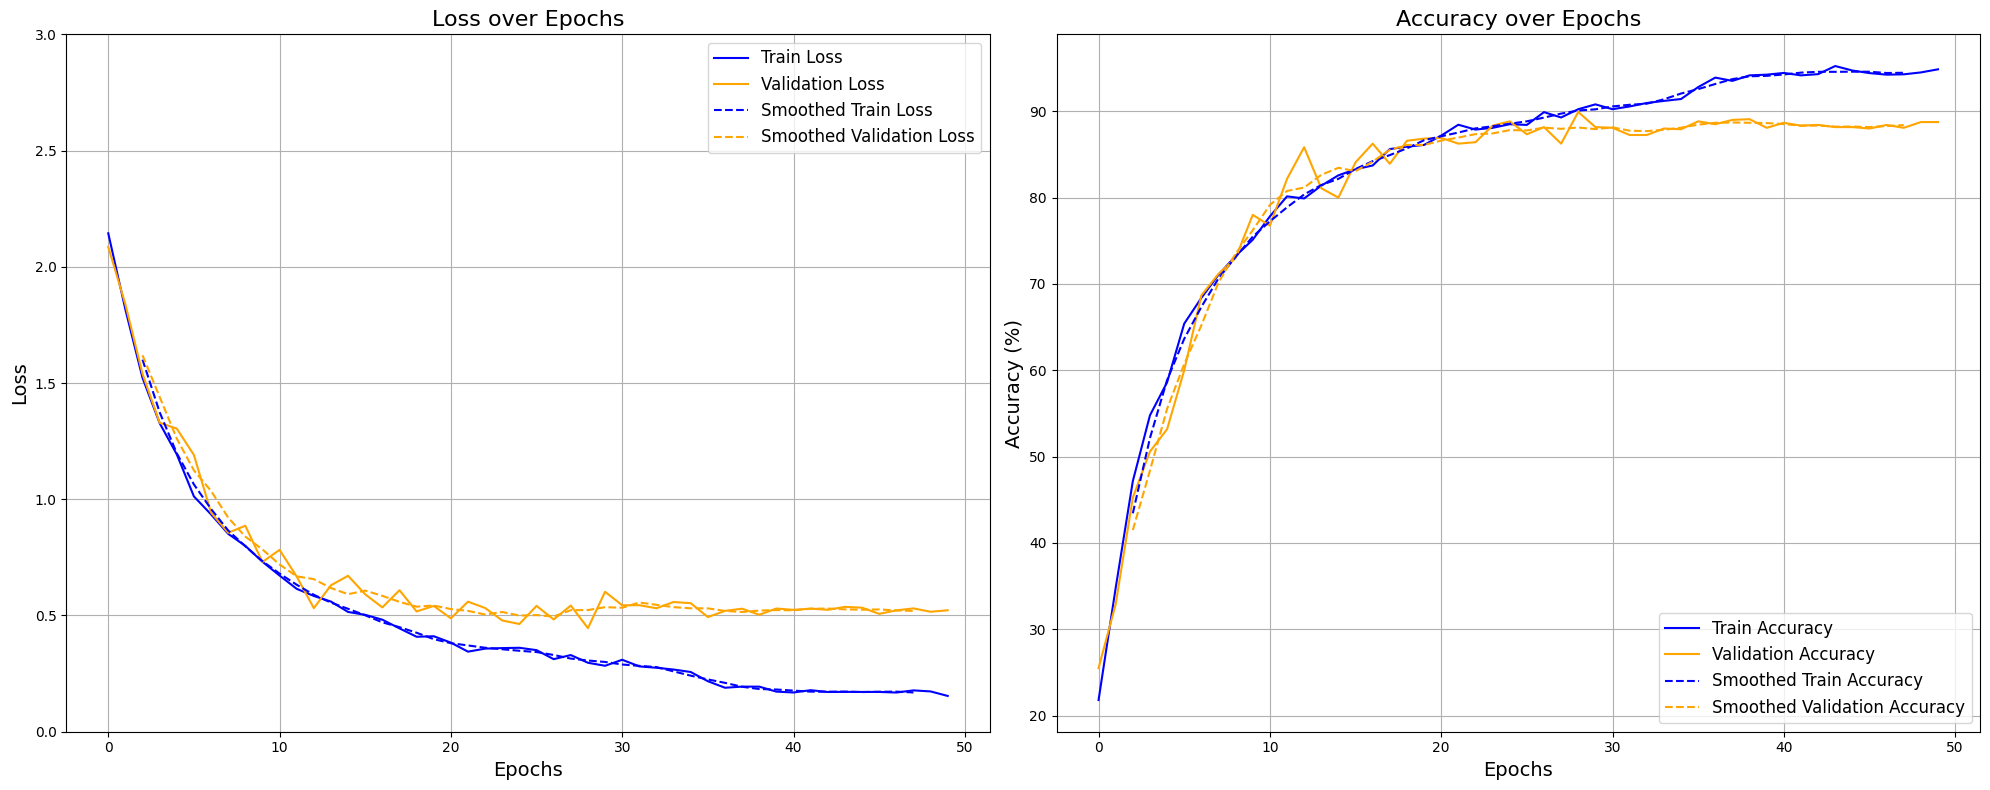

In [8]:
from Models.OutputAggregation import OutputAggregation

model = OutputAggregation(device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

model.train_(
    num_epochs=50,
    optimizer=optimizer,
    scheduler=ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5),
    criterion=nn.CrossEntropyLoss(),
    train_loader=frameimage_train_loader,
    val_loader=frameimage_val_loader,
    plot=True
)

test_results['output_aggregation']['with_leakage'] = model.eval_(
    criterion=nn.CrossEntropyLoss(),
    test_loader=frameimage_test_loader
)

with open('results.json', 'w') as f:
    json.dump(test_results, f, indent=4)

### 1.2.2. Late fusion with MLP

Epoch 50/50:
 Train Loss: 1.9043	 Train Accuracy: 26.40%
 Validation Loss: 2.0044	 Validation Accuracy: 23.33%


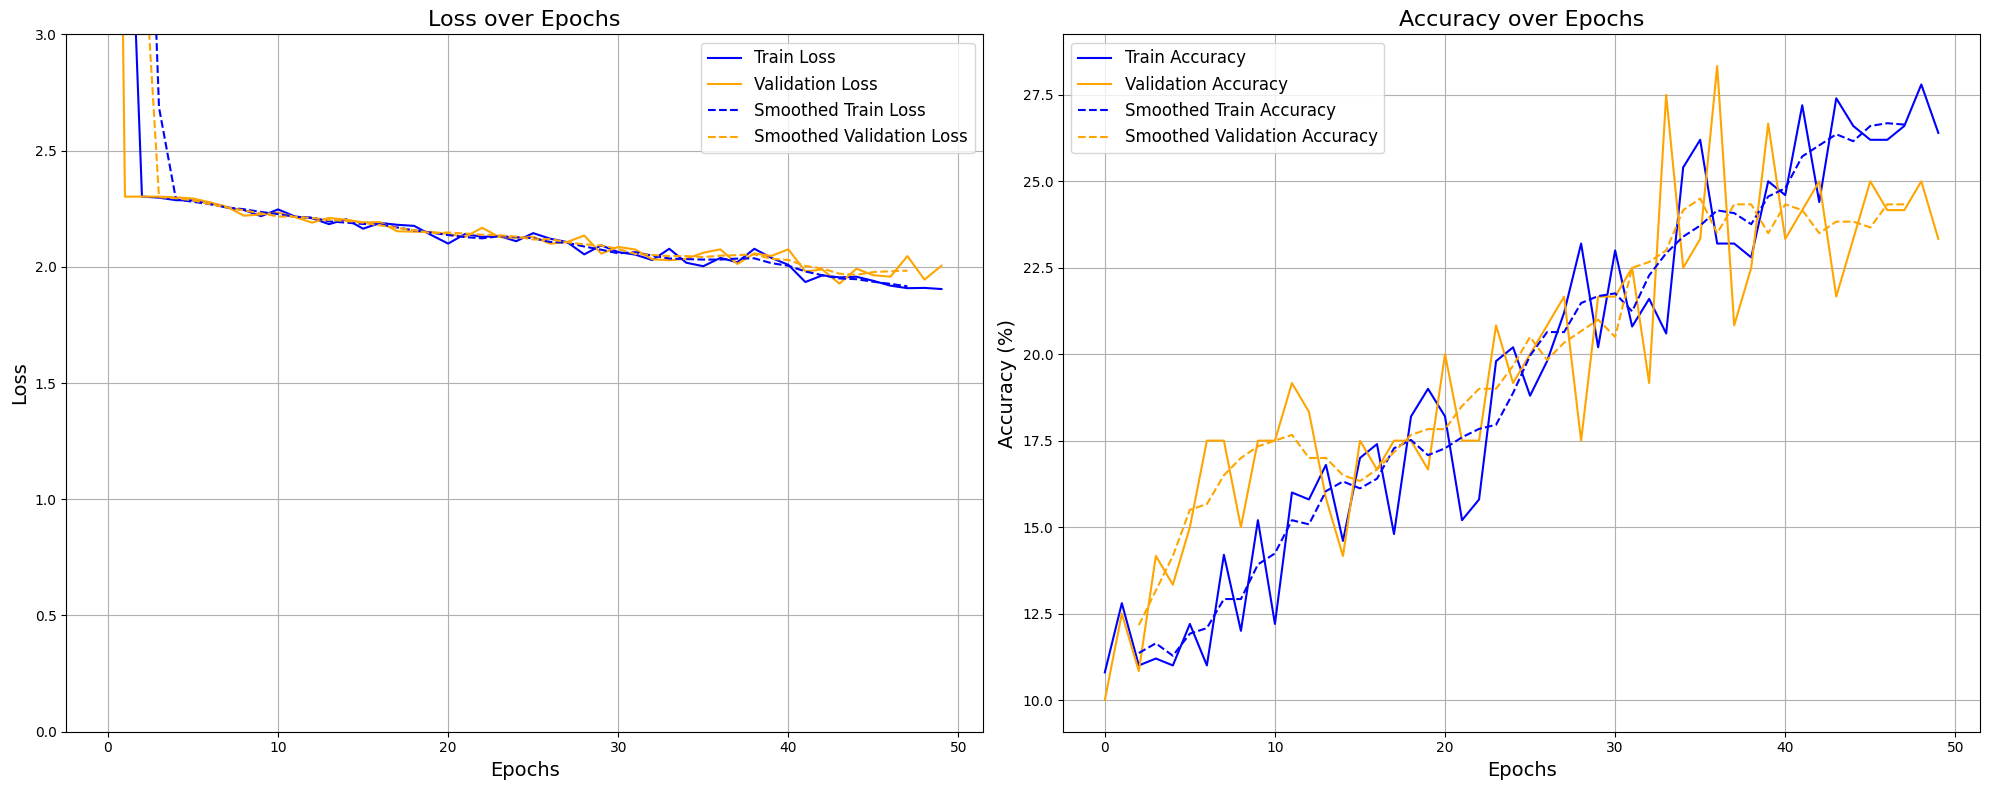

In [9]:
from Models.LateFusionMLP import LateFusionMLP

model = LateFusionMLP(device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

model.train_(
    num_epochs=50,
    optimizer=optimizer,
    scheduler=ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5),
    criterion=nn.CrossEntropyLoss(),
    train_loader=framevideolist_train_loader,
    val_loader=framevideolist_val_loader,
    plot=True
)

test_results['late_fusion_mlp']['with_leakage'] = model.eval_(
    criterion=nn.CrossEntropyLoss(),
    test_loader=framevideolist_test_loader
)

with open('results.json', 'w') as f:
    json.dump(test_results, f, indent=4)

### 1.2.3. Late fusion with Pooling

Epoch 50/50:
 Train Loss: 0.1206	 Train Accuracy: 99.60%
 Validation Loss: 0.4042	 Validation Accuracy: 87.50%


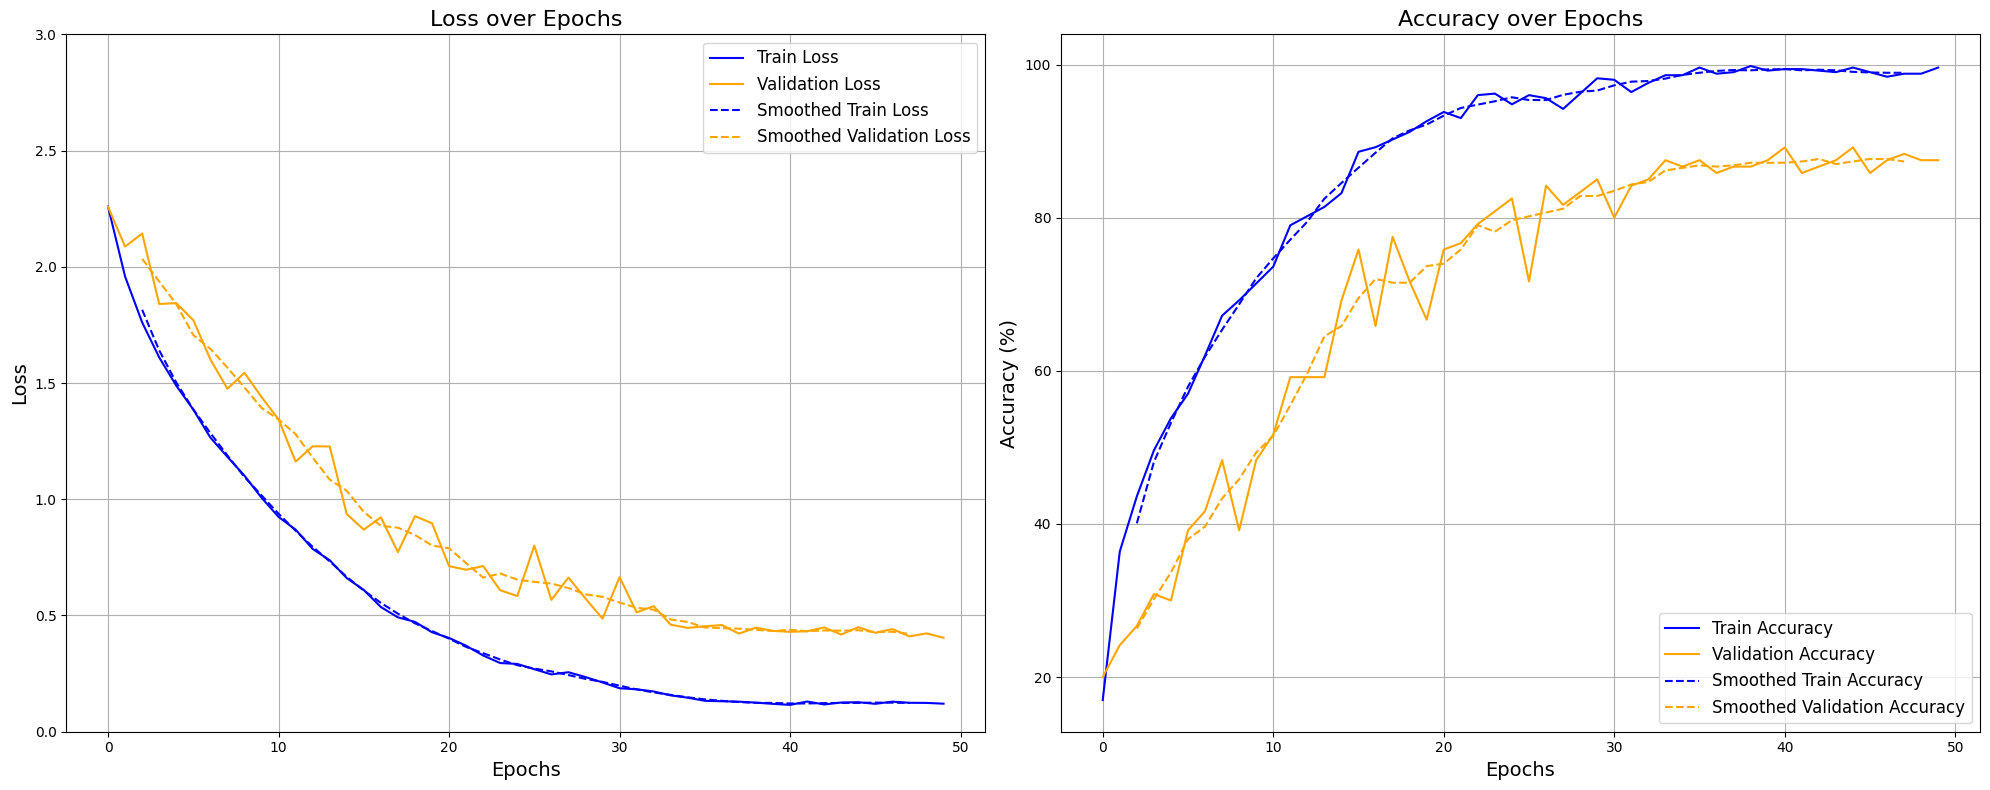

In [10]:
from Models.LateFusionPooling import LateFusionPooling
from torch.optim.lr_scheduler import ReduceLROnPlateau

model = LateFusionPooling(device).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

model.train_(
    num_epochs=50,
    optimizer=optimizer,
    scheduler=ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True),
    criterion=nn.CrossEntropyLoss(),
    train_loader=framevideolist_train_loader,
    val_loader=framevideolist_val_loader,
    plot=True
)

test_results['late_fusion_pooling']['with_leakage'] = model.eval_(
    criterion=nn.CrossEntropyLoss(),
    test_loader=framevideolist_test_loader
)

with open('results.json', 'w') as f:
    json.dump(test_results, f, indent=4)

### 1.2.4. Early fusion

Epoch 50/50:
 Train Loss: 1.5469	 Train Accuracy: 46.40%
 Validation Loss: 1.7999	 Validation Accuracy: 35.00%


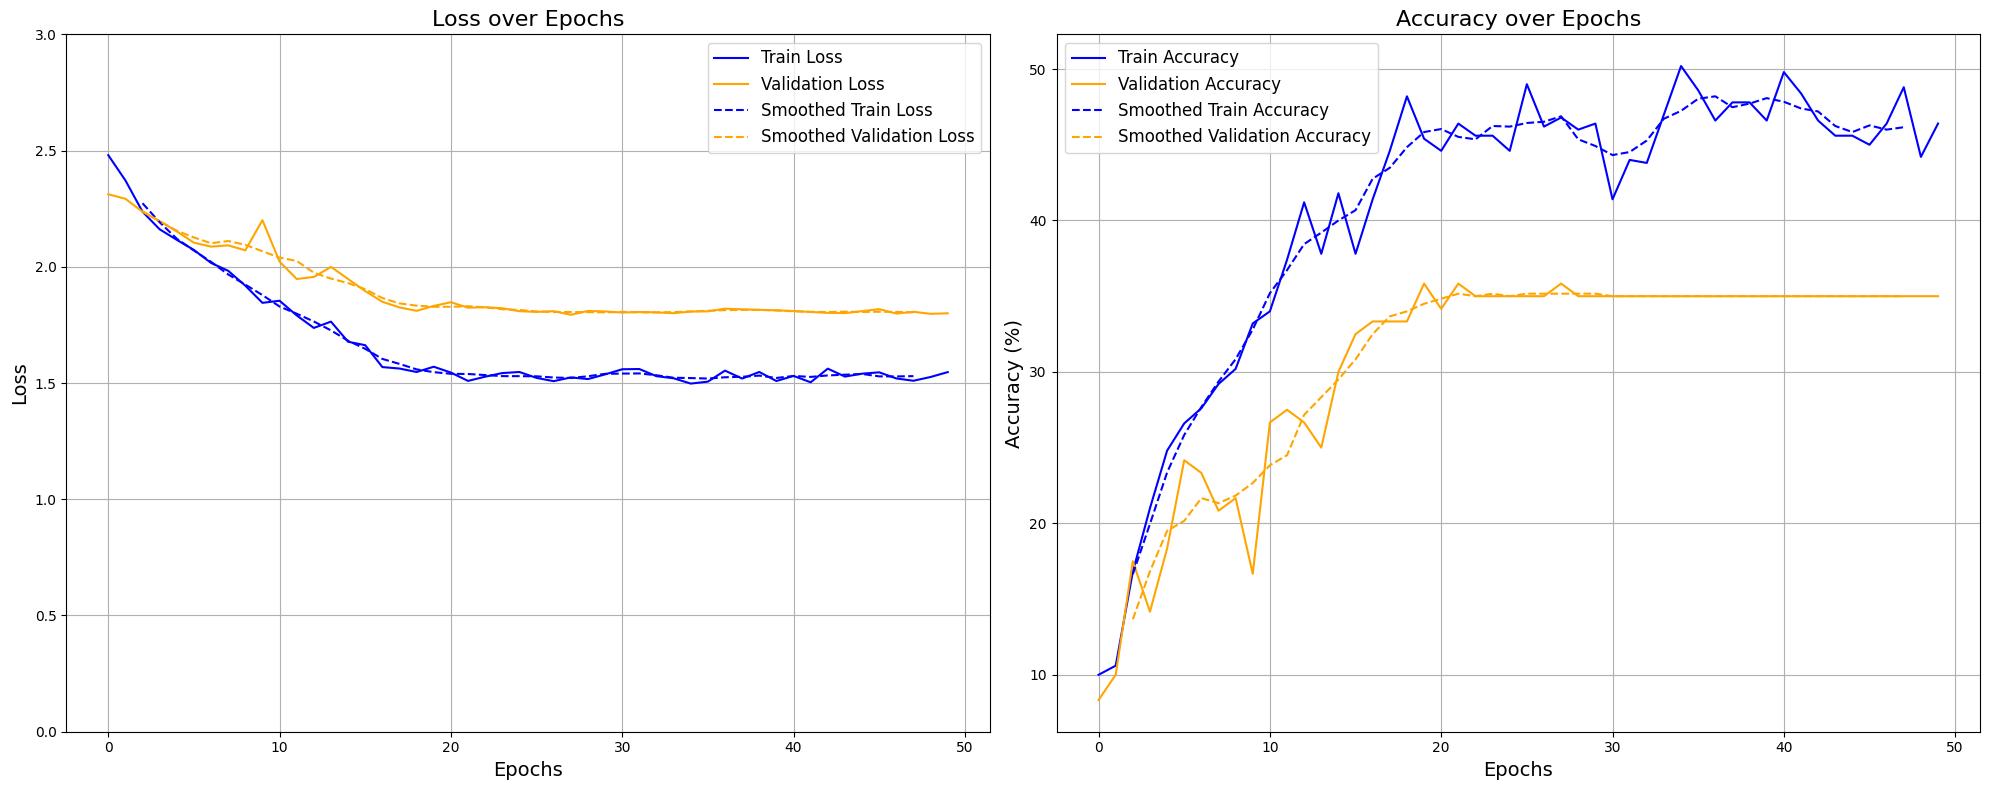

In [11]:
from Models.EarlyFusion import EarlyFusion

model = EarlyFusion(device).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

model.train_(
    num_epochs=50,
    optimizer=optimizer,
    scheduler=ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True),
    criterion=nn.CrossEntropyLoss(),
    train_loader=framevideolist_train_loader,
    val_loader=framevideolist_val_loader,
    plot=True
)

test_results['early_fusion']['with_leakage'] = model.eval_(
    criterion=nn.CrossEntropyLoss(),
    test_loader=framevideolist_test_loader
)

with open('results.json', 'w') as f:
    json.dump(test_results, f, indent=4)

### 1.2.5. 3D CNN

Epoch 50/50:
 Train Loss: 0.4418	 Train Accuracy: 86.40%
 Validation Loss: 0.9997	 Validation Accuracy: 73.33%


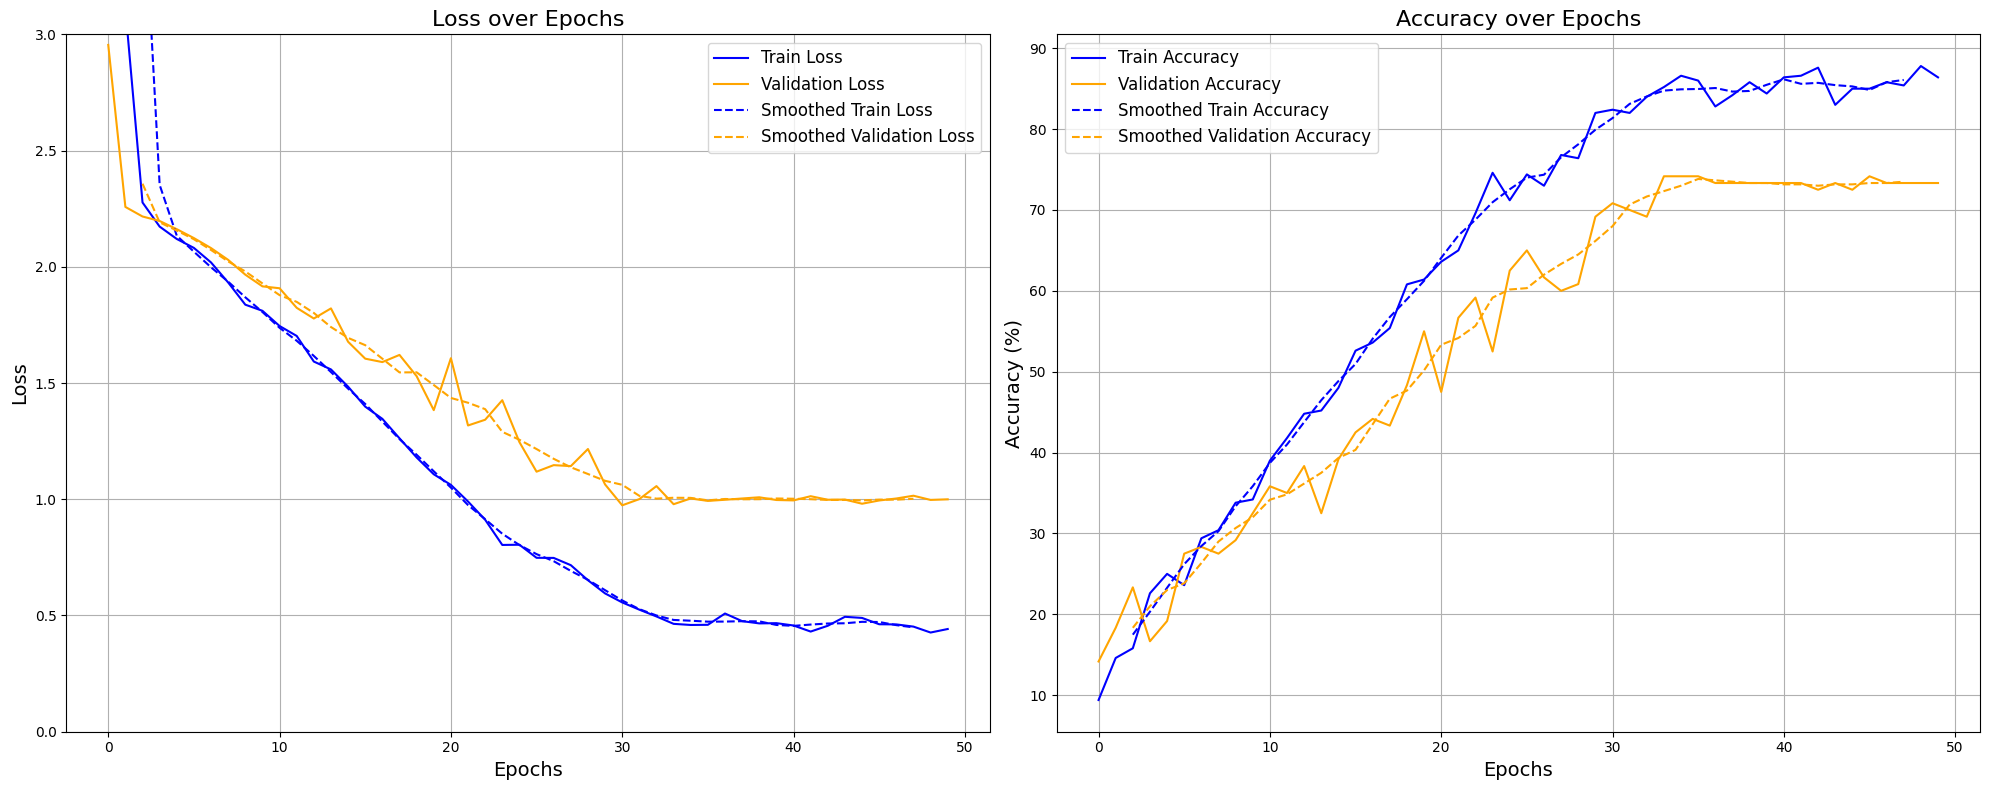

In [12]:
from Models.CNN3D import CNN3D

model = CNN3D(device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

model.train_(
    num_epochs=50,
    optimizer=optimizer,
    scheduler=ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True),
    criterion=nn.CrossEntropyLoss(),
    train_loader=framevideolist_train_loader,
    val_loader=framevideolist_val_loader,
    plot=True
)

test_results['3D_CNN']['with_leakage'] = model.eval_(
    criterion=nn.CrossEntropyLoss(),
    test_loader=framevideolist_test_loader
)

with open('results.json', 'w') as f:
    json.dump(test_results, f, indent=4)

- - -
- - -
# 2. Without leakage

## 2.1. Load the dataset

In [13]:
frameimage_train_loader_no_leakage = DataLoader(
    dataset=FrameImageDataset(split='train', transform=train_transform, leakage=False), 
    batch_size=BATCH_SIZE, 
    shuffle=True
)
frameimage_val_loader_no_leakage = DataLoader(
    dataset=FrameImageDataset(split='val', transform=val_test_transform, leakage=False), 
    batch_size=BATCH_SIZE, 
    shuffle=True
)
frameimage_test_loader_no_leakage = DataLoader(
    dataset=FrameImageDataset(split='test', transform=val_test_transform, leakage=False), 
    batch_size=BATCH_SIZE, 
    shuffle=True
)

In [14]:
framevideolist_train_loader_no_leakage = DataLoader(
    dataset=FrameVideoDataset(split='train', transform=train_transform, leakage=False, stack_frames=False), 
    batch_size=BATCH_SIZE, 
    shuffle=True
)
framevideolist_val_loader_no_leakage = DataLoader(
    dataset=FrameVideoDataset(split='val', transform=val_test_transform, leakage=False, stack_frames=False), 
    batch_size=BATCH_SIZE, 
    shuffle=True
)
framevideolist_test_loader_no_leakage = DataLoader(
    dataset=FrameVideoDataset(split='test', transform=val_test_transform, leakage=False, stack_frames=False), 
    batch_size=BATCH_SIZE, 
    shuffle=True
)

## 2.2. Train the models

In [15]:
criterion = nn.CrossEntropyLoss()

### 2.2.1. Output aggregation

Epoch 50/50:
 Train Loss: 0.2205	 Train Accuracy: 92.96%
 Validation Loss: 4.5005	 Validation Accuracy: 22.33%


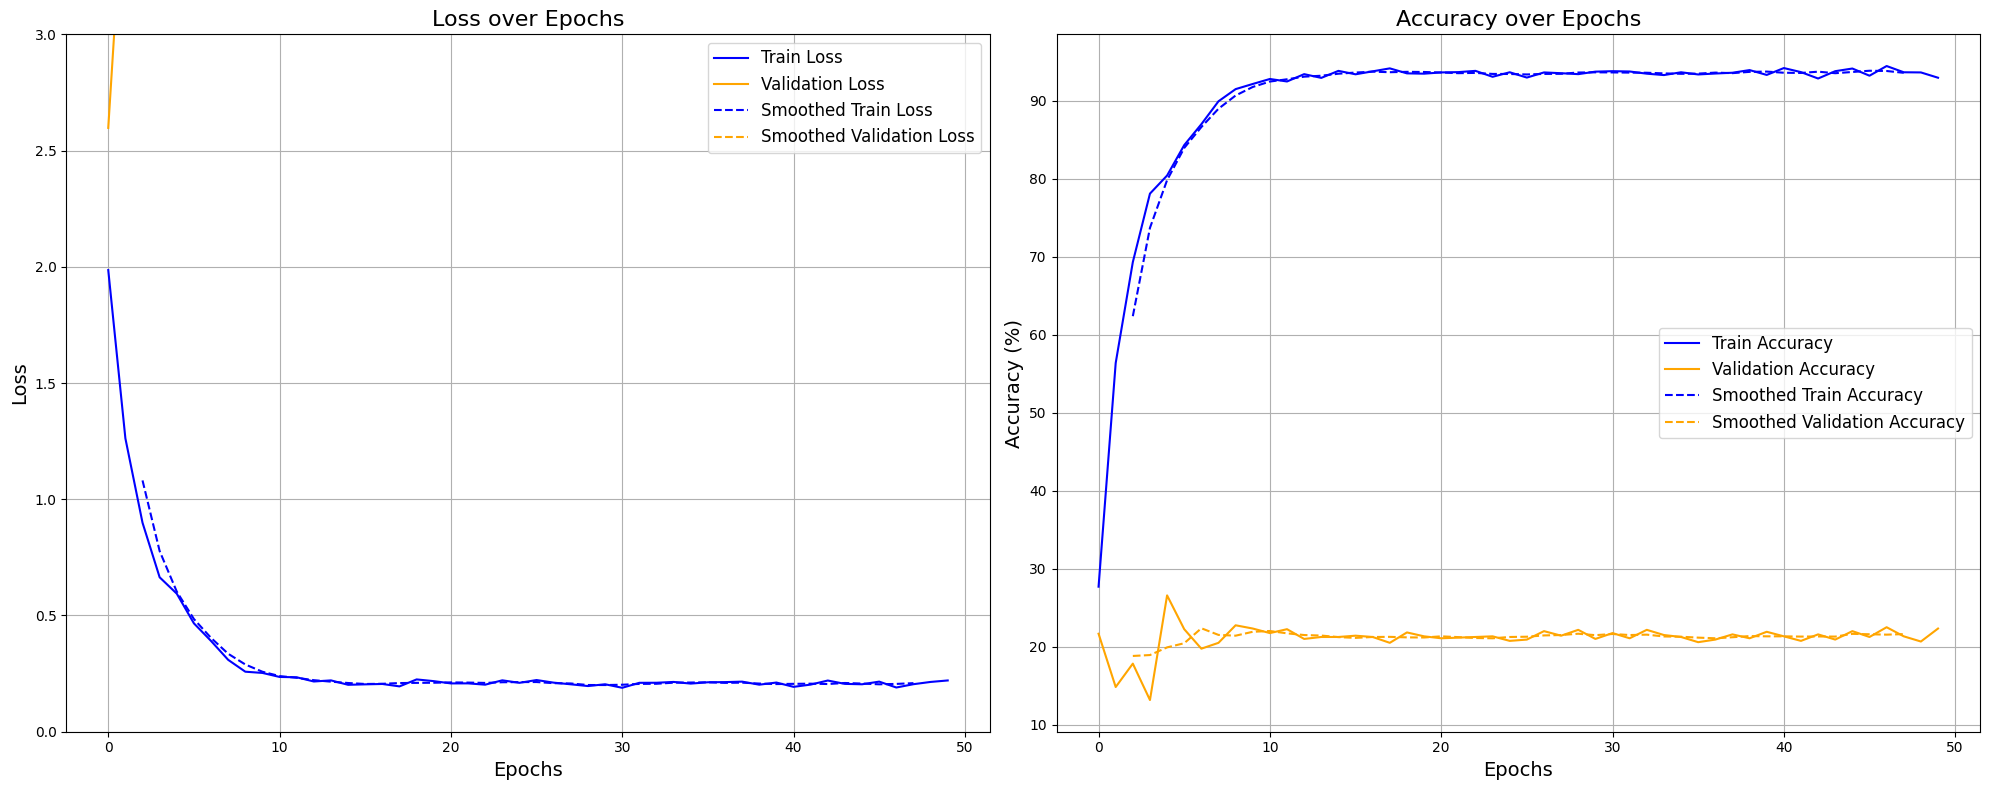

In [16]:
from Models.OutputAggregation import OutputAggregation
from torch.optim.lr_scheduler import ReduceLROnPlateau

model = OutputAggregation(device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

model.train_(
    num_epochs=50,
    optimizer=optimizer,
    scheduler=ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5),
    criterion=criterion,
    train_loader=frameimage_train_loader_no_leakage,
    val_loader=frameimage_val_loader_no_leakage,
    plot=True
)

test_results['output_aggregation']['without_leakage'] = model.eval_( 
    criterion=criterion,
    test_loader=frameimage_test_loader_no_leakage
)

with open('results.json', 'w') as f:
    json.dump(test_results, f, indent=4)

### 2.2.2. Late fusion with MLP

Epoch 50/50:
 Train Loss: 1.9556	 Train Accuracy: 27.60%
 Validation Loss: 2.4523	 Validation Accuracy: 20.00%


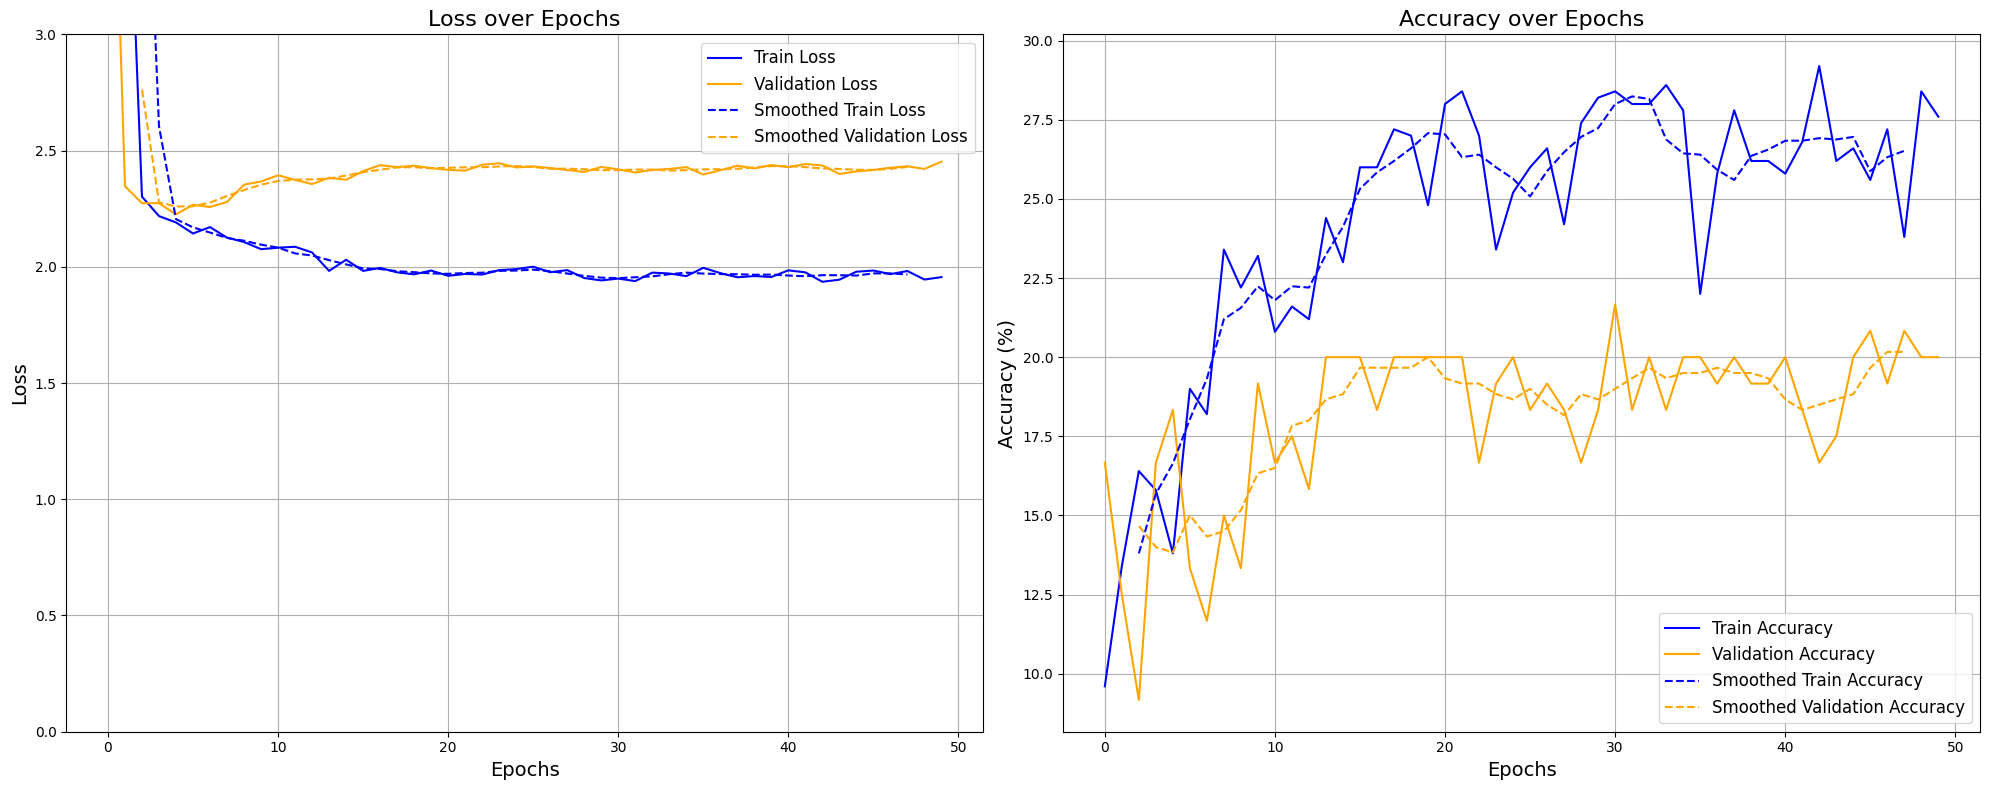

In [ ]:
from Models.LateFusionMLP import LateFusionMLP

model = LateFusionMLP(device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

model.train_(
    num_epochs=50,
    optimizer=optimizer,
    scheduler=ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5),
    criterion=criterion,
    train_loader=framevideolist_train_loader_no_leakage,
    val_loader=framevideolist_val_loader_no_leakage,
    plot=True
)

test_results['late_fusion_mlp']['without_leakage'] = model.eval_(
    criterion=criterion,
    test_loader=framevideolist_test_loader_no_leakage
)

with open('results.json', 'w') as f:
    json.dump(test_results, f, indent=4)

### 2.2.3. Late fusion with Pooling

Epoch 50/50:
 Train Loss: 0.6622	 Train Accuracy: 87.60%
 Validation Loss: 2.5653	 Validation Accuracy: 18.33%


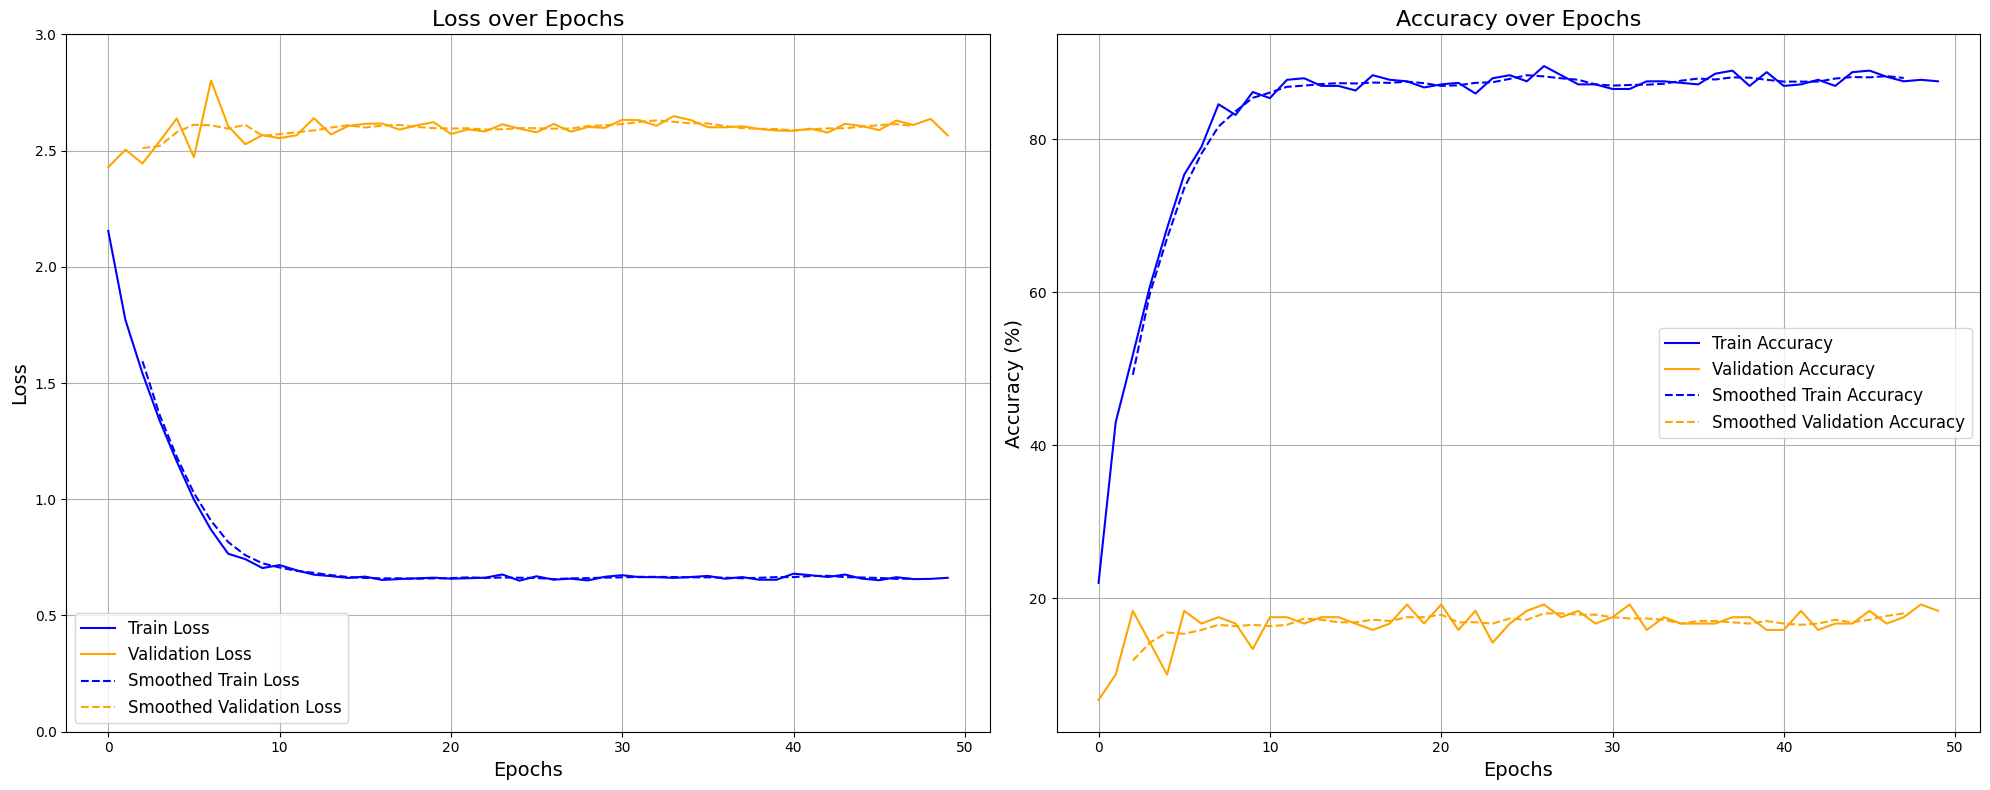

In [ ]:
from Models.LateFusionPooling import LateFusionPooling
from torch.optim.lr_scheduler import ReduceLROnPlateau

model = LateFusionPooling(device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

model.train_(
    num_epochs=50,
    optimizer=optimizer,
    scheduler=ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5),
    criterion=criterion,
    train_loader=framevideolist_train_loader_no_leakage,
    val_loader=framevideolist_val_loader_no_leakage,
    plot=True
)

test_results['late_fusion_pooling']['without_leakage'] = model.eval_(
    criterion=criterion,
    test_loader=framevideolist_test_loader_no_leakage
)

with open('results.json', 'w') as f:
    json.dump(test_results, f, indent=4)

### 2.2.4. Early fusion

Epoch 50/50:
 Train Loss: 1.4094	 Train Accuracy: 52.80%
 Validation Loss: 2.3010	 Validation Accuracy: 20.83%


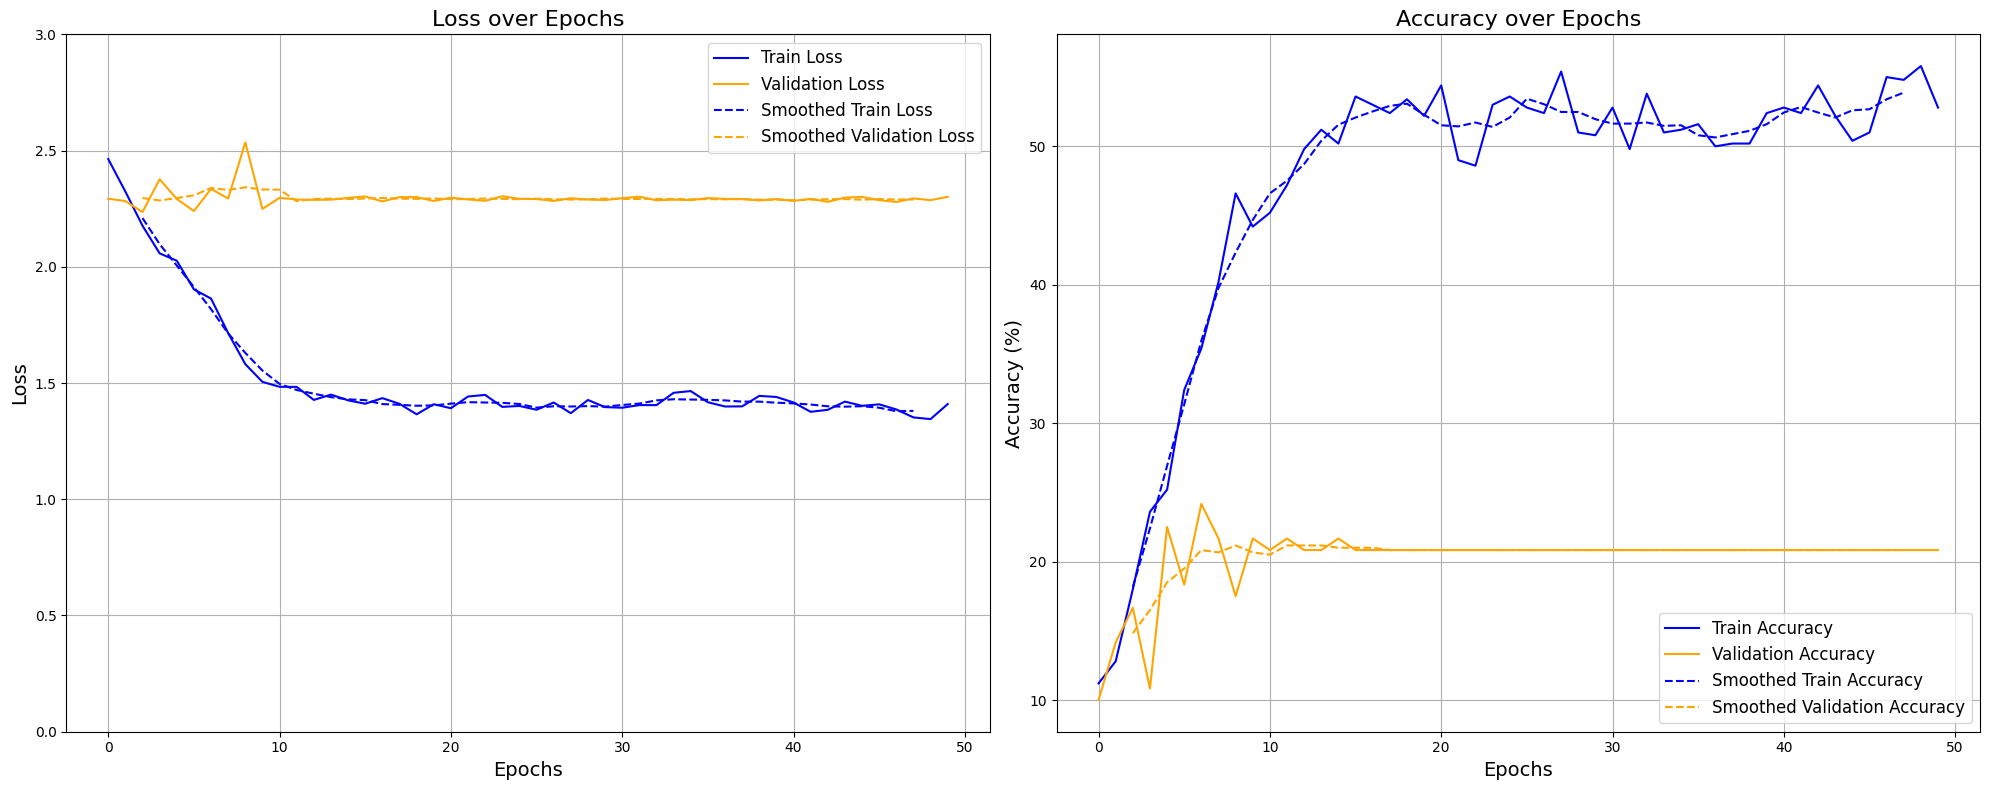

In [ ]:
from Models.EarlyFusion import EarlyFusion

model = EarlyFusion(device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

model.train_(
    num_epochs=50,
    optimizer=optimizer,
    scheduler=ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5),
    criterion=nn.CrossEntropyLoss(),
    train_loader=framevideolist_train_loader_no_leakage,
    val_loader=framevideolist_val_loader_no_leakage,
    plot=True
)

test_results['early_fusion']['without_leakage'] = model.eval_(
    criterion=nn.CrossEntropyLoss(),
    test_loader=framevideolist_test_loader_no_leakage
)

with open('results.json', 'w') as f:
    json.dump(test_results, f, indent=4)

### 2.2.5. 3D CNN

Epoch 50/50:
 Train Loss: 0.6789	 Train Accuracy: 80.00%
 Validation Loss: 3.1651	 Validation Accuracy: 20.00%


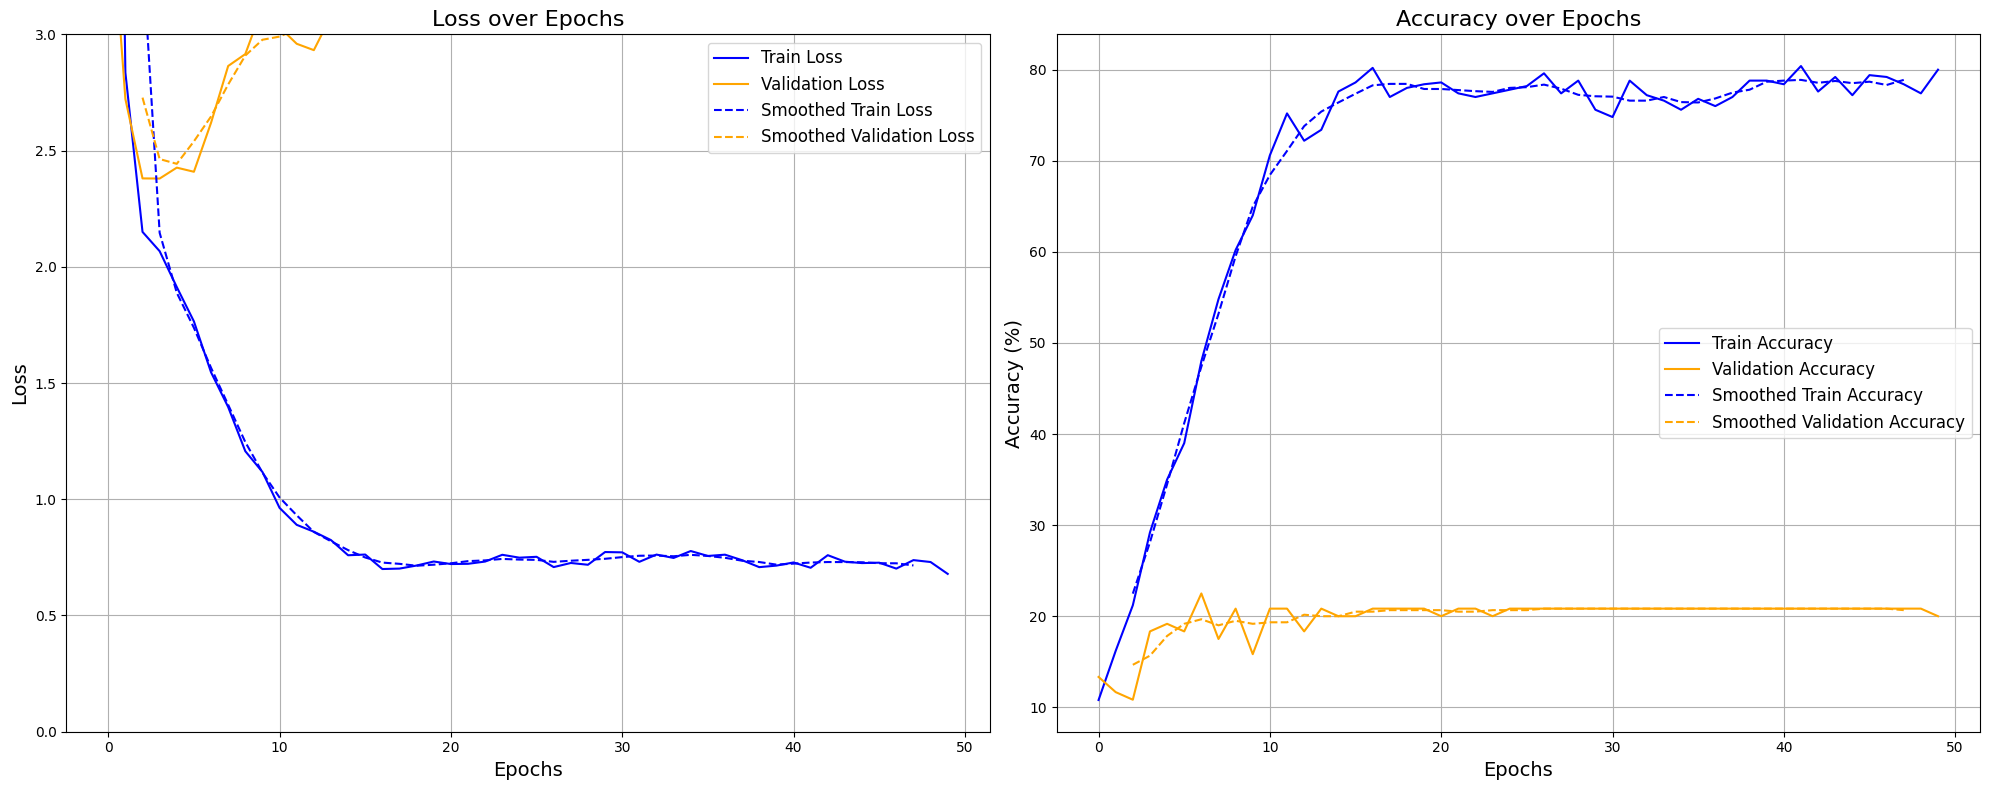

In [ ]:
from Models.CNN3D import CNN3D

model = CNN3D(device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

model.train_(
    num_epochs=50,
    optimizer=optimizer,
    scheduler=ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5),
    criterion=nn.CrossEntropyLoss(),
    train_loader=framevideolist_train_loader_no_leakage,
    val_loader=framevideolist_val_loader_no_leakage,
    plot=True
)

test_results['3D_CNN']['without_leakage'] = model.eval_(
    criterion=nn.CrossEntropyLoss(),
    test_loader=framevideolist_test_loader_no_leakage
)

with open('results.json', 'w') as f:
    json.dump(test_results, f, indent=4)

- - -
- - -
# 3. Dual Stream model

In [21]:
flow_transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),                   
    T.Normalize(mean=[0.5] * 2, std=[0.5] * 2),
])

In [22]:
from DatasetLoader.FlowVideoDataset import FlowVideoDataset

flowvideo_train_loader = DataLoader(
    dataset=FlowVideoDataset(split='train', transform=flow_transform), 
    batch_size=BATCH_SIZE, 
    shuffle=True
)

flowvideo_val_loader = DataLoader(
    dataset=FlowVideoDataset(split='val', transform=flow_transform), 
    batch_size=BATCH_SIZE, 
    shuffle=False
)

flowvideo_test_loader = DataLoader(
    dataset=FlowVideoDataset(split='test', transform=flow_transform), 
    batch_size=BATCH_SIZE, 
    shuffle=False
)

In [23]:
from collections import Counter

train_labels = [label for _, label in frameimage_train_loader.dataset]
class_counts = Counter(train_labels)

In [24]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(train_labels)
class_weights = compute_class_weight('balanced', classes=classes, y=train_labels)
print(f"Class Counts: {class_counts}")

Class Counts: Counter({0: 500, 1: 500, 2: 500, 4: 500, 3: 500, 5: 500, 6: 500, 7: 500, 8: 500, 9: 500})


In [25]:
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print(f"Class Weights: {class_weights}")

Class Weights: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')


In [26]:
from Models.DualStream import DualStream
model = DualStream(device).to(device)

In [27]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
criterion = nn.CrossEntropyLoss()

c:\Users\longo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 50/50:
 Train Loss: 0.9397	 Train Accuracy: 96.60%
 Validation Loss: 1.6498	 Validation Accuracy: 61.67%


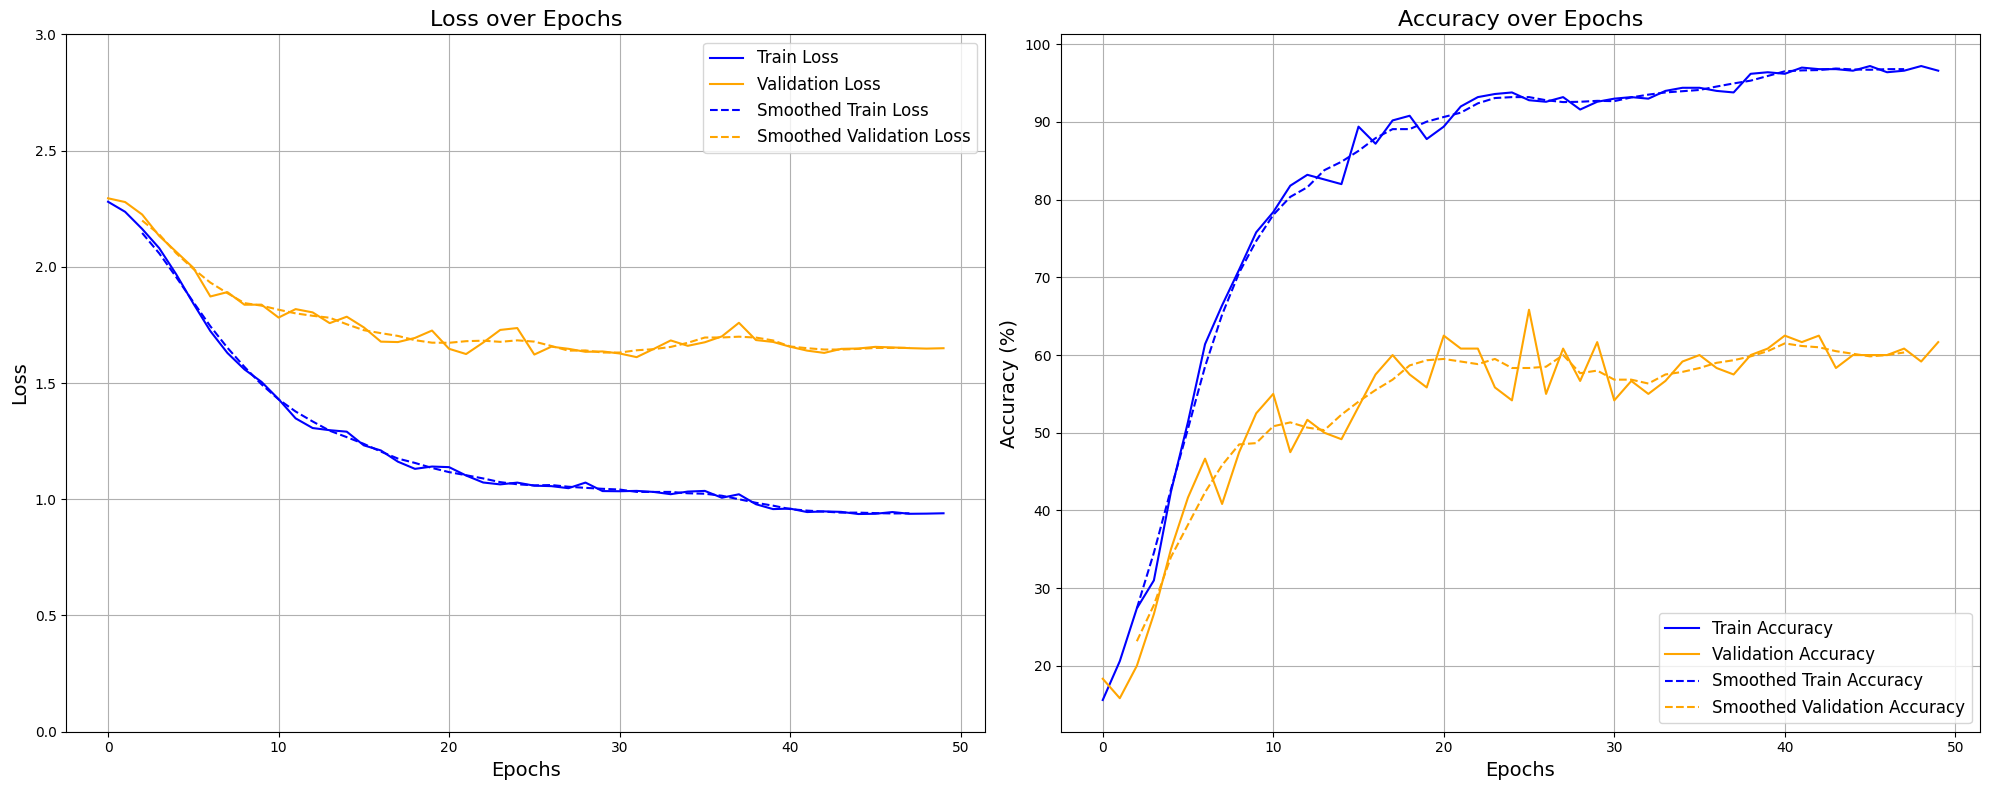

In [ ]:
model.train_(
    num_epochs=50,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    train_loader=flowvideo_train_loader,
    val_loader=flowvideo_val_loader,
    plot=True
)

test_results['dual_stream']['without_leakage'] = model.eval_(
    criterion=criterion,
    test_loader=flowvideo_test_loader
)

with open('results.json', 'w') as f:
    json.dump(test_results, f, indent=4)